In [ ]:
import numpy as np

# Naive Bayes Classifier

- It is a generative classifier
- estimates probability belonging to a class using Bayes Theorem:
$$posterior = \frac{prior \times likelihood}{evidence}$$
$$p(y|x) = \frac{p(y) \times p(x|y)}{p(x)}$$

- Likelihood. an be expressed as :
$$p(x|y) = p(x_1,x_2,x_3...,x_m|y)=p(x_1|y)p(x_2|y).....p(x_m|y)$$
$$=\prod_{j=1}^mp(x_j|y)$$


## Bernoulli NB: Implementation

### Parameter: estimation: class conidtional density and prior
**class conidtional density**
$$\mathbf{w}_{jy_c} = \frac{\sum_{i=1}^n1(y^{(i)}=y_c)x_j^{(i)}}{\sum_{i=1}^n1(y^{(i)}=y_c)}$$
What does it mean? Average of feature value $x_j$ in examples with label $y_c$
- $1(y^{(i)}=y_c)$ gets us the example with label $y_c$
- Denominator sums up $x_j$ across all examples with label $y_c$
- And is divided by the total number of examples with label $y_c$

The **class prior** is obtained as foolows:
$$\mathbf{w}_{y_c} = \frac{\sum_{i=1}^n1(y^{(i)}=y_c)}{n}$$


While estimating parameters of the model,we process examples from each ;abe; separately and estimate the parameters.

In [ ]:
def fit(X,y):
  n_samples, n_features = X.shape
  class_count = np.unique(y)
  n_classes = len(class_count)

  #initialize the weight vectors
  w= np.zeros((n_classes, n_features), dtype=np.float64)
  w_priors = np.zeros(n_classes, dtype=np.float64)

  for c in range(n_classes): #processing examples from each class separately
  #get examples with label=c
    X_c = X[y==c]

    #estimation of w_{jy_c}: The parameter of Bernoulli distribution
    #p(x_j|y_c) - Ber(w_{jy_c})
    #We have vectorized this operation and we obtain vector w_{y_c} that
    #contains w_{jy_c} for each x_j
    w[c,:]= np.sum(X_c,axis=0)/X_c.shape[0]

    #estimation of prior probability:w_{y_c}
    w_priors[c] = X_c.shape[0]/float(n_samples)

  print("Weight vector: ",w)
  print("Prior: ",w_priors)
  return w, w_priors




In [ ]:
#feature matrix with shape (4,2). x_1-Ber(w_1), x_2-Ber(w_2)
X=np.array([[1,0],[0,1],[0,1],[1,0]])

#label vector with shape(4,)
y=np.array([1,0,0,1])

#call fit with features matrix and label vector as arguments
fit(X,y)


Weight vector:  [[0. 1.]
 [1. 0.]]
Prior:  [0.5 0.5]


(array([[0., 1.],
        [1., 0.]]), array([0.5, 0.5]))

A few observations:
- since there are 50% examples of each class 1 and 0, the prior probability vector has 0.5 for each class.
- Note that
  - for class=0, $x_1$=0 and $x_2$=1 and hence the parameters of bernoullu distributions are 0 and 1 respectively.
    - $w_{01}=0, w_{02}=1$
  - for class=1, $x_1$=1 and $x_2$=0 and hence the parameters of bernoullu distributions are 1 and 0 respectively.
    - $w_{11}=1, w_{21}=0$
  

Let's understand class conditional density calculation step by step:<br>
 **STEP-1:** Filter examples for a class, say c=1

In [ ]:
X_c = X[y==1]
X_c

array([[1, 0],
       [1, 0]])

Feature wise sum

In [ ]:
np.sum(X_c,axis=0)

array([2, 0])

Dividing by class count

In [ ]:
w= np.sum(X_c,axis=0)/X_c.shape[0]
w

array([1., 0.])

### Incorporating Laplace correction
AS we talked in the lecture slides, the 0 value for parameter is a proble, as it leads to 0 posterior probability. We can fix this proble, with **Laplace correction** or by adding a small dummy counts in each class for each feature.

- The class priors with laplace correction can be calculated as follows:

$$\mathbf{w}_{y_c} = \frac{\sum_{i=1}^n1(y^{(i)}=y_c) + \alpha}{n + k\alpha}$$
- The class conditional density with laplace correction is computed as follows:
$$\mathbf{w}_{jy_c} = \frac{\sum_{i=1}^n1(y^{(i)}=y_c)x_j^{(i)}+\alpha}{\sum_{i=1}^n1(y^{(i)}=y_c)+2\alpha}$$
In both cases we use $\alpha$=1.(Laplace correction or smoothing)

### Inference

#### Determine class label
We assign class label $y_c$ that results in the largest product of likelihood and prior

$$y_c = argmax_{y_c}\left(\sum_{j=1}^m x_jlog w_{jy_c}+(1-x_j)log(1-w_{jy_c})\right)+logp(y_c;\mathbf{w})$$
Further with vectorization, this is implemented as follows:
$$y = argmax_y\mathbf{X}log\mathbf{w}^T + (1-\mathbf{X})log(1-\mathbf{w})^T + log \mathbf{w}_{prior}$$

### Implementation

In [ ]:
class BernoulliNB(object):
  def __init__(self,alpha=1.0):
    self.alpha=alpha
  def fit(self,X,y):
    n_samples, n_features = X.shape
    class_count = np.unique(y)
    n_classes = len(class_count)

    #initialize the weight vectors
    self.w= np.zeros((n_classes, n_features), dtype=np.float64)
    self.w_priors = np.zeros(n_classes, dtype=np.float64)

    for c in range(n_classes): #processing examples from each class separately
    #get examples with label=c
      X_c = X[y==c]

      #estimation of w_{jy_c}: The parameter of Bernoulli distribution
      #p(x_j|y_c) - Ber(w_{jy_c})
      #We have vectorized this operation and we obtain vector w_{y_c} that
      #contains w_{jy_c} for each x_j
      self.w[c,:]= (np.sum(X_c,axis=0)+self.alpha)/(X_c.shape[0]+2*self.alpha)

      #estimation of prior probability:w_{y_c}
      self.w_priors[c] = (X_c.shape[0]+self.alpha)/(float(n_samples)+n_classes*self.alpha)

    print("Weight vector: ",self.w)
    print("Prior: ",self.w_priors)
  def log_likelihood_prior_prod(self,X):
    return X@(np.log(self.w).T)+(1-X)@np.log((1-self.w).T)+np.log(self.w_priors)
  
  def predict_proba(self,X):
    q=self.log_likelihood_prior_prod(X)
    return np.exp(q)/np.expand_dims(np.sum(np.exp(q),axis=1),axis=1)

  def predict(self,X):
    return np.argmax(self.log_likelihood_prior_prod(X),axis=1)

### Demos

#### Binary classification setup

In [ ]:
bernoulli_nb= BernoulliNB()
bernoulli_nb.fit(X,y)

Weight vector:  [[0.25 0.75]
 [0.75 0.25]]
Prior:  [0.5 0.5]


In [ ]:
bernoulli_nb.predict(X)

array([1, 0, 0, 1])

In [ ]:
bernoulli_nb.log_likelihood_prior_prod(X)

array([[-3.4657359 , -1.26851133],
       [-1.26851133, -3.4657359 ],
       [-1.26851133, -3.4657359 ],
       [-3.4657359 , -1.26851133]])

In [ ]:
bernoulli_nb.predict_proba(X)

array([[0.1, 0.9],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.1, 0.9]])

#### Multiclass classification setup

In [ ]:
X=np.array([[1,0],[0,1],[0,1],[1,0],[1,1],[1,1]])
y=np.array([1,0,0,1,2,2])

In [ ]:
bernoulli_nb= BernoulliNB()
bernoulli_nb.fit(X,y)

Weight vector:  [[0.25 0.75]
 [0.75 0.25]
 [0.75 0.75]]
Prior:  [0.33333333 0.33333333 0.33333333]


In [ ]:
bernoulli_nb.predict(X)

array([1, 0, 0, 1, 2, 2])

In [ ]:
bernoulli_nb.log_likelihood_prior_prod(X)

array([[-3.87120101, -1.67397643, -2.77258872],
       [-1.67397643, -3.87120101, -2.77258872],
       [-1.67397643, -3.87120101, -2.77258872],
       [-3.87120101, -1.67397643, -2.77258872],
       [-2.77258872, -2.77258872, -1.67397643],
       [-2.77258872, -2.77258872, -1.67397643]])

In [ ]:
bernoulli_nb.predict_proba(X)

array([[0.07692308, 0.69230769, 0.23076923],
       [0.69230769, 0.07692308, 0.23076923],
       [0.69230769, 0.07692308, 0.23076923],
       [0.07692308, 0.69230769, 0.23076923],
       [0.2       , 0.2       , 0.6       ],
       [0.2       , 0.2       , 0.6       ]])

## Gaussian NB:Implementation

$$p(x_j|y_c) \sim \mathcal{N}(\mu_{jc},\sigma_{jc}^2)$$
There are m$\times$k Gaussian distributions-one for each feature and label.<br>
Each Gaussian distribution has 2 parametrs to estimate hence the total number of parameters are $2\times m \times k$

### Parameter estimation

Let $n_r$ is the total number of samples with label $y_r$.
$$n_r = \sum_{i=1}^n1(y^{(i)}=y_r)$$
the parameters for multivariate Gaussian for label r can be calculated as follows:
$$\mu_r = \frac{1}{n_r}\sum_{i=1}^n1(y^{(i)}=y_r)x^{(i)}$$
$${\scriptstyle \sum_{jjr}^2} =\frac{1}{n_r}\sum_{i=1}^n1(y^{(i)}=y_r)(x^{(i)}-\mu_r)^2 $$

### Inference

It is interseting to note that
- we calculate the distance between the mean and the sample normalized by the variance: $\frac{1}{2}(x-\mu_c)^T{\scriptstyle \sum_{c}^{-1}}(x-\mu_c)$
- we calculate exponential of this distance and convert it into probability by dividing it with $(2\pi)^{d/2}|{\scriptstyle \sum_{c}}|^{1/2}$

### Implementation

In [ ]:
class GaussianNB(object):
  def fit(self,X,y):
    '''parameter estimation for gaussian distribution'''
    n_samples, n_features=X.shape
    self._classes = np.unique(y)
    n_classes = len(self._classes)

    #calculate mean, variance and prior for each class.
    self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
    self._var = np.zeros((n_classes, n_features), dtype=np.float64)
    self._priors = np.zeros(n_classes, dtype=np.float64)

    for idx, c in enumerate(self._classes):
      #Get examples with label $c$
      X_c = X[y==c]

      #estimate mean from the training examples of class $c$.
      self._mean[idx,:] = X_c.mean(axis=0)

      #estimate standard deviation from the training examples of class $c$
      self._var[idx,:]=X_c.var(axis=0)

      #estimate the priors- based on fraction of examples with label c
      #among all the training examples.
      self._priors[idx] = X_c.shape[0]/float(n_samples)

    print("Mean: ",self._mean)
    print("Variance: ",self._var)
    print("Priors: ",self._priors)

  def _calc_pdf(self,class_idx,X):
    ''' calculate probability density for samples for class label class_idx'''
    mean=self._mean[class_idx]
    var= np.diag(self._var[class_idx])
    z= np.power(2*np.pi,X.shape[0]/2)*np.power(np.linalg.det(var),1/2)
    return (1/z)*np.exp(-(1/2)*(X-mean).T@(np.linalg.inv(var))@(X-mean))

  def _calc_prod_likelihood_prior(self,X):
    self._prod_likelihood_prior = np.zeros((X.shape[0], len(self._classes)),
                                           dtype=np.float64)
    for x_idx, x in enumerate(X):
      for idx, c in enumerate(self._classes):
        self._prod_likelihood_prior[x_idx,c] = (
            np.log(self._calc_pdf(idx,x))+ np.log(self._priors[idx]
                                                  ))
  def predict(self,X):
    self._calc_prod_likelihood_prior(X)
    return np.argmax(self._prod_likelihood_prior,axis=1)

  def predict_proba(self,X):
    self._calc_prod_likelihood_prior(X)
    return np.exp(self._prod_likelihood_prior)/np.expand_dims(
        np.sum(np.exp(self._prod_likelihood_prior),axis=1), axis=1)


### Demo

#### Binary classification
- Generates examples fromtwo classes
- Divide data into train and test
- Train the model in the examples from triaing set
- Evaluate the classification performance on the test set

**STEP:1** Generate the training data with two multi-variate Faussian distribution one with mean [5,5] and the seconf one with mean [10,10] and standard deviation of 1.5 for each Gaussian
- The number of features per example =2
- Total number of examples =100

In [ ]:
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split

#generate artificaial data poiunts
X,y = make_blobs(n_samples=100,
                 n_features=2,
                 centers=[[5,5],[10,10]],
                 cluster_std=1.5,
                 random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)

In [ ]:
gaussian_nb=GaussianNB()
gaussian_nb.fit(X_train,y_train)

Mean:  [[ 4.55853975  5.01739665]
 [10.30431548 10.08580617]]
Variance:  [[2.13298417 2.30222002]
 [3.22242307 2.20662074]]
Priors:  [0.5125 0.4875]


Observe that since each example has two features and we have two classes, we have
- Mean vector for each class has two components- mean for feature 1 and mean for feature 2.
- Variance also has two entries- one for variance of feature 1 and feature 2. Note that we are only storing the diagonal elements of covariance matrix for each class label
- There are two priors-one for each class

Since we are performing parameter estimation on examples generated from the known distributions, we can compare the estimated means with the actual means.

**STEP:3** Plot the gaussian distribution

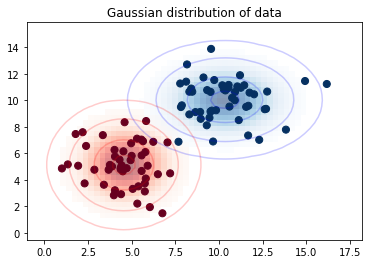

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
ax.scatter(X[:,0],X[:,1],c=y,s=50,cmap='RdBu')

xlim = (min(X[:,0])-2, max(X[:,0])+2)
ylim = (min(X[:,1])-2, max(X[:,1])+2)

xg = np.linspace(xlim[0],xlim[1],60)
yg = np.linspace(ylim[0],ylim[1],40)
xx,yy = np.meshgrid(xg,yg)
Xgrid = np.vstack([xx.ravel(),yy.ravel()]).T

for label, color in enumerate(['red','blue']):
  mask = (y==label)
  mu,std = X[mask].mean(0), X[mask].std(0)
  P= np.exp(-0.5*(Xgrid-mu)**2/std**2).prod(1)
  Pm = np.ma.masked_array(P,P<0.03)
  ax.pcolorfast(xg,yg,Pm.reshape(xx.shape),alpha=0.5,
                cmap =color.title()+'s')
  ax.contour(xx,yy,P.reshape(xx.shape),
             levels = [0.01,0.1,0.5,0.9],
             colors=color, alpha=0.2)
ax.set(xlim=xlim, ylim=ylim)

plt.title('Gaussian distribution of data')
plt.show()


**STEP:4** Let's test the inference procedire on test data

In [ ]:
gaussian_nb.predict(X_test)

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, gaussian_nb.predict(X_test)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        11

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [ ]:
gaussian_nb.predict_proba(X_test)

array([[9.99999746e-01, 2.54140753e-07],
       [7.63749214e-14, 1.00000000e+00],
       [4.23038642e-03, 9.95769614e-01],
       [9.99986614e-01, 1.33855473e-05],
       [7.05769182e-06, 9.99992942e-01],
       [9.99820566e-01, 1.79433743e-04],
       [9.72541524e-01, 2.74584756e-02],
       [9.99982043e-01, 1.79572091e-05],
       [2.85910189e-05, 9.99971409e-01],
       [1.01888837e-07, 9.99999898e-01],
       [7.39129058e-01, 2.60870942e-01],
       [9.99793438e-01, 2.06561658e-04],
       [9.99999915e-01, 8.46737165e-08],
       [2.03213294e-05, 9.99979679e-01],
       [8.76198350e-09, 9.99999991e-01],
       [6.51163513e-05, 9.99934884e-01],
       [9.27638525e-05, 9.99907236e-01],
       [7.58034673e-09, 9.99999992e-01],
       [1.81773339e-03, 9.98182267e-01],
       [9.99985544e-01, 1.44557945e-05]])

- Let's make prediction for new data point

In [ ]:
x_new = np.array([1.5,6.5])

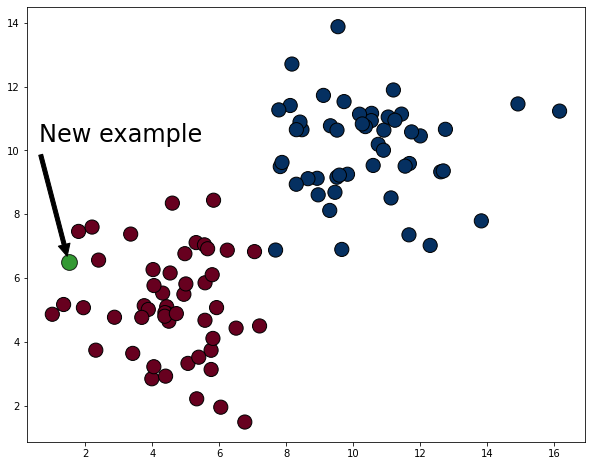

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(X[:,0],X[:,1],c=y,marker='o',s=200,edgecolor='k',cmap='RdBu')
plt.scatter(x_new[0],x_new[1],marker='o',c='green',
            s=250, edgecolor='k',alpha=0.8)
plt.annotate('New example',xy=x_new,
             xytext=(-30,120),textcoords='offset points',
             arrowprops=dict(facecolor='black',shrink=0.05),fontsize=24)
plt.show()

In [ ]:
gaussian_nb.predict_proba(np.array([x_new]))

array([[9.99996296e-01, 3.70449944e-06]])

#### Multiclass Classification

In [ ]:
X,y = make_blobs(n_samples=100,
                 n_features=2,
                 centers=[[5,5],[10,10],[20,20]],
                 cluster_std=1.5,
                 random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)

In [ ]:
gaussian_nb_multiclass=GaussianNB()
gaussian_nb_multiclass.fit(X_train,y_train)

Mean:  [[ 4.32493295  4.9261512 ]
 [10.08933823 10.24358143]
 [20.35823887 19.98964827]]
Variance:  [[1.90119065 1.75508118]
 [2.59281953 2.84758455]
 [3.33357766 2.13450451]]
Priors:  [0.3375 0.325  0.3375]


In [ ]:
print(classification_report(y_test, gaussian_nb_multiclass.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [ ]:
gaussian_nb_multiclass.predict_proba(X_test)

array([[9.99999928e-01, 7.23480157e-08, 5.52753526e-45],
       [3.07192942e-81, 3.48932416e-27, 1.00000000e+00],
       [9.05566491e-47, 9.00980814e-12, 1.00000000e+00],
       [8.73880553e-07, 9.99999126e-01, 2.13601466e-18],
       [4.30463605e-07, 9.99999570e-01, 2.43424450e-19],
       [9.99861723e-01, 1.38276697e-04, 1.73980847e-36],
       [9.71571910e-01, 2.84280896e-02, 2.02611143e-29],
       [9.99945259e-01, 5.47409390e-05, 5.17560432e-40],
       [2.30798895e-55, 4.04296544e-15, 1.00000000e+00],
       [4.33364087e-63, 7.38273060e-19, 1.00000000e+00],
       [5.99300948e-01, 4.00699052e-01, 1.17062404e-26],
       [9.99596696e-01, 4.03304033e-04, 8.00915783e-37],
       [9.99998963e-01, 1.03741568e-06, 9.69221547e-47],
       [1.42516102e-06, 9.99998575e-01, 5.00159588e-21],
       [2.49627685e-66, 2.20643778e-20, 1.00000000e+00],
       [2.56803484e-06, 9.99997432e-01, 1.48253549e-18],
       [6.95188906e-06, 9.99993048e-01, 5.97611895e-20],
       [6.84555927e-66, 2.16888

## Multinomial NB: Implementation

We use **multinomial naive Bayes classifier** for problems like **document classifier**
- We represent i-th document with a feature vector $x^{(i)}$ containing counts of words in the vocabulary {$x_1^{(i)},x_2^{(i)},......,x_m^{(i)}$}
- The sum of all feature counts is equal to the total number of words in the document: $\sum_{i=1}^mx_j^{(i)}=l$

In mathematical terms:
$$x|y_r \sim Multinomial(w_{1y},w_{2y}...w_{my})$$
$$\sim Multinomial(w_{y_r}) $$

The total number if parameters = m $\times$ k+k where
- m $\times$ k is the total number if features for k multinomial distributions and
- k is the total number of priors

### Parameter Estimation

The j-th component of parameter vector $w_{y_r}$ for multinomial distribution of calss $y_r$ is calculated as follows:

$$ w_{jy_r} = \frac{\sum_{i=1}^n1(y^{(i)}=y_r)x_j^{(i)}}{\sum_{i=1}^n1(y^{(i)}=y_r)\sum_{i=1}^mx_j^{(i)}} $$

with Laplace correction:
$$ w_{jy_r} = \frac{\sum_{i=1}^n1(y^{(i)}=y_r)x_j^{(i)}+\alpha}{\sum_{i=1}^n1(y^{(i)}=y_r)\sum_{i=1}^mx_j^{(i)}+m\alpha} $$

### Inference
In log space the calculation is performed as follows:
- In the numerator, we first multiply the count matrix with transpose of log ow weight vector and add it to the log of prior probabilities. and exponentiate the resulting value.
- the denominator, we perform the same calculation as numerator but for different class labels.and sum them up.
- the denominator normalizes the numerator between 0 and 1, thus giving us the posterior probability of label $y_c$ for the given count vector x.
$$p(y_c|x;l,w_{y_c} = \frac{exp(X(log w_{y_c})^T+ logp(y_c))}{\sum_rexp(X(log w_{y_r})^T+ logp(y_r)}$$

### Implementation

In [ ]:
class MultinomialNB(object):
    def fit(self,X,y,alpha=1):
      '''implements parameter estimation for multinomial distribution'''
      n_samples, n_features=X.shape
      self._classes = np.unique(y)
      n_classes = len(self._classes)

      #calculate parameters of k multinomial distributions and priors
      self.w = np.zeros((n_classes, n_features), dtype=np.float64)
      self.w_priors = np.zeros(n_classes, dtype=np.float64)

      for idx, c in enumerate(self._classes):
        X_c = X[y==c]
        #get the total count for class c
        total_count = np.sum(np.sum(X_c,axis=1))

        #estimate parameters of multnomial distribution for class c
        self.w[idx,:]=(np.sum(X_c,axis=0)+alpha)/(total_count+alpha*n_features)

        #estimate class prior for class c
        self.w_priors[idx] = (X_c.shape[0]+alpha)/float(n_samples+alpha*n_classes)
    def log_likelihood_prior_prod(self,X):
      return X@(np.log(self.w).T)+np.log(self.w_priors)
  
    def predict_proba(self,X):
      q=self.log_likelihood_prior_prod(X)
      return np.exp(q)/np.expand_dims(np.sum(np.exp(q),axis=1),axis=1)

    def predict(self,X):
      return np.argmax(self.log_likelihood_prior_prod(X),axis=1)

### Demo

#### Binary setup

In [ ]:
rng = np.random.RandomState(1)
X=rng.randint(5,size=(1000,5))
y=rng.randint(2,size=(1000,))

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
print("Shape of feature matrix: ", X_train.shape)
print("shape of label vector: ", y_train.shape)


Shape of feature matrix:  (750, 5)
shape of label vector:  (750,)


In [ ]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(X_train,y_train)

In [ ]:
print("Prior: ",multinomial_nb.w_priors)
print("Parameters of multinomial distribution: \n", multinomial_nb.w)

Prior:  [0.47739362 0.52260638]
Parameters of multinomial distribution: 
 [[0.22272598 0.18560499 0.18843865 0.19892321 0.20430717]
 [0.20752367 0.20353762 0.19431988 0.20154459 0.19307424]]


In [ ]:
print(classification_report(y_test, multinomial_nb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.47      0.29      0.36       127
           1       0.47      0.66      0.55       123

    accuracy                           0.47       250
   macro avg       0.47      0.47      0.46       250
weighted avg       0.47      0.47      0.45       250



In [ ]:
multinomial_nb.predict_proba(X_test[:5])

array([[0.36261992, 0.63738008],
       [0.46437814, 0.53562186],
       [0.45472261, 0.54527739],
       [0.45786583, 0.54213417],
       [0.40820134, 0.59179866]])

#### Multiclass Setup

In [ ]:
rng = np.random.RandomState(1)
X=rng.randint(5,size=(1000,5))
y=rng.randint(3,size=(1000,))

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(X_train,y_train)
print("Prior: ",multinomial_nb.w_priors)
print("Parameters of multinomial distribution: \n", multinomial_nb.w)

Prior:  [0.35856574 0.3373174  0.30411687]
Parameters of multinomial distribution: 
 [[0.20608229 0.19642218 0.18962433 0.20071556 0.20715564]
 [0.21274038 0.18910256 0.20392628 0.20192308 0.19230769]
 [0.22154911 0.19904803 0.1912592  0.1912592  0.19688447]]


In [ ]:
print(classification_report(y_test, multinomial_nb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.29      0.58      0.38        78
           1       0.27      0.26      0.27        89
           2       0.22      0.02      0.04        83

    accuracy                           0.28       250
   macro avg       0.26      0.29      0.23       250
weighted avg       0.26      0.28      0.23       250



In [ ]:
multinomial_nb.predict_proba(X_test[:5])

array([[0.2995798 , 0.44926752, 0.25115268],
       [0.30652604, 0.43310705, 0.26036691],
       [0.30652604, 0.43310705, 0.26036691],
       [0.31660766, 0.40912157, 0.27427077],
       [0.32933811, 0.37778415, 0.29287774]])